# Dimensional Diversity Analysis

We know the cluster has 125 unique vectors in 2560D space. But how is the diversity distributed across dimensions?

For each of the 2,560 dimensions, let's count:
- How many distinct bfloat16 values appear across the 125 vectors?
- Are values evenly spread or clustered?
- Which dimensions show the most/least diversity?

This will tell us: Is the cluster a hypercube in *all* dimensions, or just *most*?

## Parameters

In [1]:
# Paths
CLUSTER_TOKENS_PATH = '../tensors/Qwen3-4B-Instruct-2507/1.4h_cluster_tokens.safetensors'
GAMMA_PATH = '../tensors/Qwen3-4B-Instruct-2507/W.safetensors'

# Analysis
TOP_N_DIMS = 10  # Show top N most diverse dimensions

# Visualization
DPI = 200

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt

## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
# Load cluster token IDs
cluster_data = load_file(CLUSTER_TOKENS_PATH)
cluster_token_ids = cluster_data['cluster_token_ids'].to(device)

print(f"Loaded {len(cluster_token_ids)} cluster token IDs")

Loaded 2212 cluster token IDs


In [5]:
# Load gamma matrix in bfloat16
gamma_data = load_file(GAMMA_PATH)
W = gamma_data['W'].to(torch.bfloat16).to(device)

print(f"Loaded gamma matrix: {W.shape}")
print(f"Precision: {W.dtype}")

Loaded gamma matrix: torch.Size([151936, 2560])
Precision: torch.bfloat16


In [6]:
# Extract cluster vectors
cluster_vectors = W[cluster_token_ids]

print(f"Extracted {cluster_vectors.shape[0]} vectors of dimension {cluster_vectors.shape[1]}")

Extracted 2212 vectors of dimension 2560


## Find Unique Vectors

In [7]:
# Find unique vectors (stay in bfloat16)
unique_vectors = torch.unique(cluster_vectors.to('cpu'), dim=0).to(device)

print(f"Found {len(unique_vectors)} unique vectors")
print(f"Precision: {unique_vectors.dtype}")

Found 125 unique vectors
Precision: torch.bfloat16


## Count Unique Values Per Dimension

In [8]:
# For each dimension, count how many distinct values appear
num_dims = unique_vectors.shape[1]
unique_counts = []

print(f"Analyzing {num_dims} dimensions...")

for d in range(num_dims):
    values = unique_vectors[:, d]
    unique_vals = torch.unique(values)
    unique_counts.append(len(unique_vals))

unique_counts = np.array(unique_counts)

print(f"Done!")

Analyzing 2560 dimensions...
Done!


## Summary Statistics

In [9]:
print("="*60)
print("DIMENSIONAL DIVERSITY SUMMARY")
print("="*60)
print(f"Total dimensions: {num_dims}")
print(f"Unique vectors: {len(unique_vectors)}")
print(f"\nUnique values per dimension:")
print(f"  Min: {unique_counts.min()}")
print(f"  Max: {unique_counts.max()}")
print(f"  Mean: {unique_counts.mean():.2f}")
print(f"  Median: {np.median(unique_counts):.0f}")
print(f"\nBreakdown by diversity:")
for n in range(1, min(11, unique_counts.max() + 1)):
    count = np.sum(unique_counts == n)
    pct = 100 * count / num_dims
    print(f"  {n} value(s): {count:4d} dimensions ({pct:5.2f}%)")
if unique_counts.max() > 10:
    count = np.sum(unique_counts > 10)
    pct = 100 * count / num_dims
    print(f"  >10 values: {count:4d} dimensions ({pct:5.2f}%)")
print("="*60)

DIMENSIONAL DIVERSITY SUMMARY
Total dimensions: 2560
Unique vectors: 125

Unique values per dimension:
  Min: 1
  Max: 84
  Mean: 5.02
  Median: 3

Breakdown by diversity:
  1 value(s):  363 dimensions (14.18%)
  2 value(s):  201 dimensions ( 7.85%)
  3 value(s): 1070 dimensions (41.80%)
  4 value(s):  187 dimensions ( 7.30%)
  5 value(s):   86 dimensions ( 3.36%)
  6 value(s):  161 dimensions ( 6.29%)
  7 value(s):   92 dimensions ( 3.59%)
  8 value(s):   35 dimensions ( 1.37%)
  9 value(s):   67 dimensions ( 2.62%)
  10 value(s):   75 dimensions ( 2.93%)
  >10 values:  223 dimensions ( 8.71%)


## Histogram of Diversity

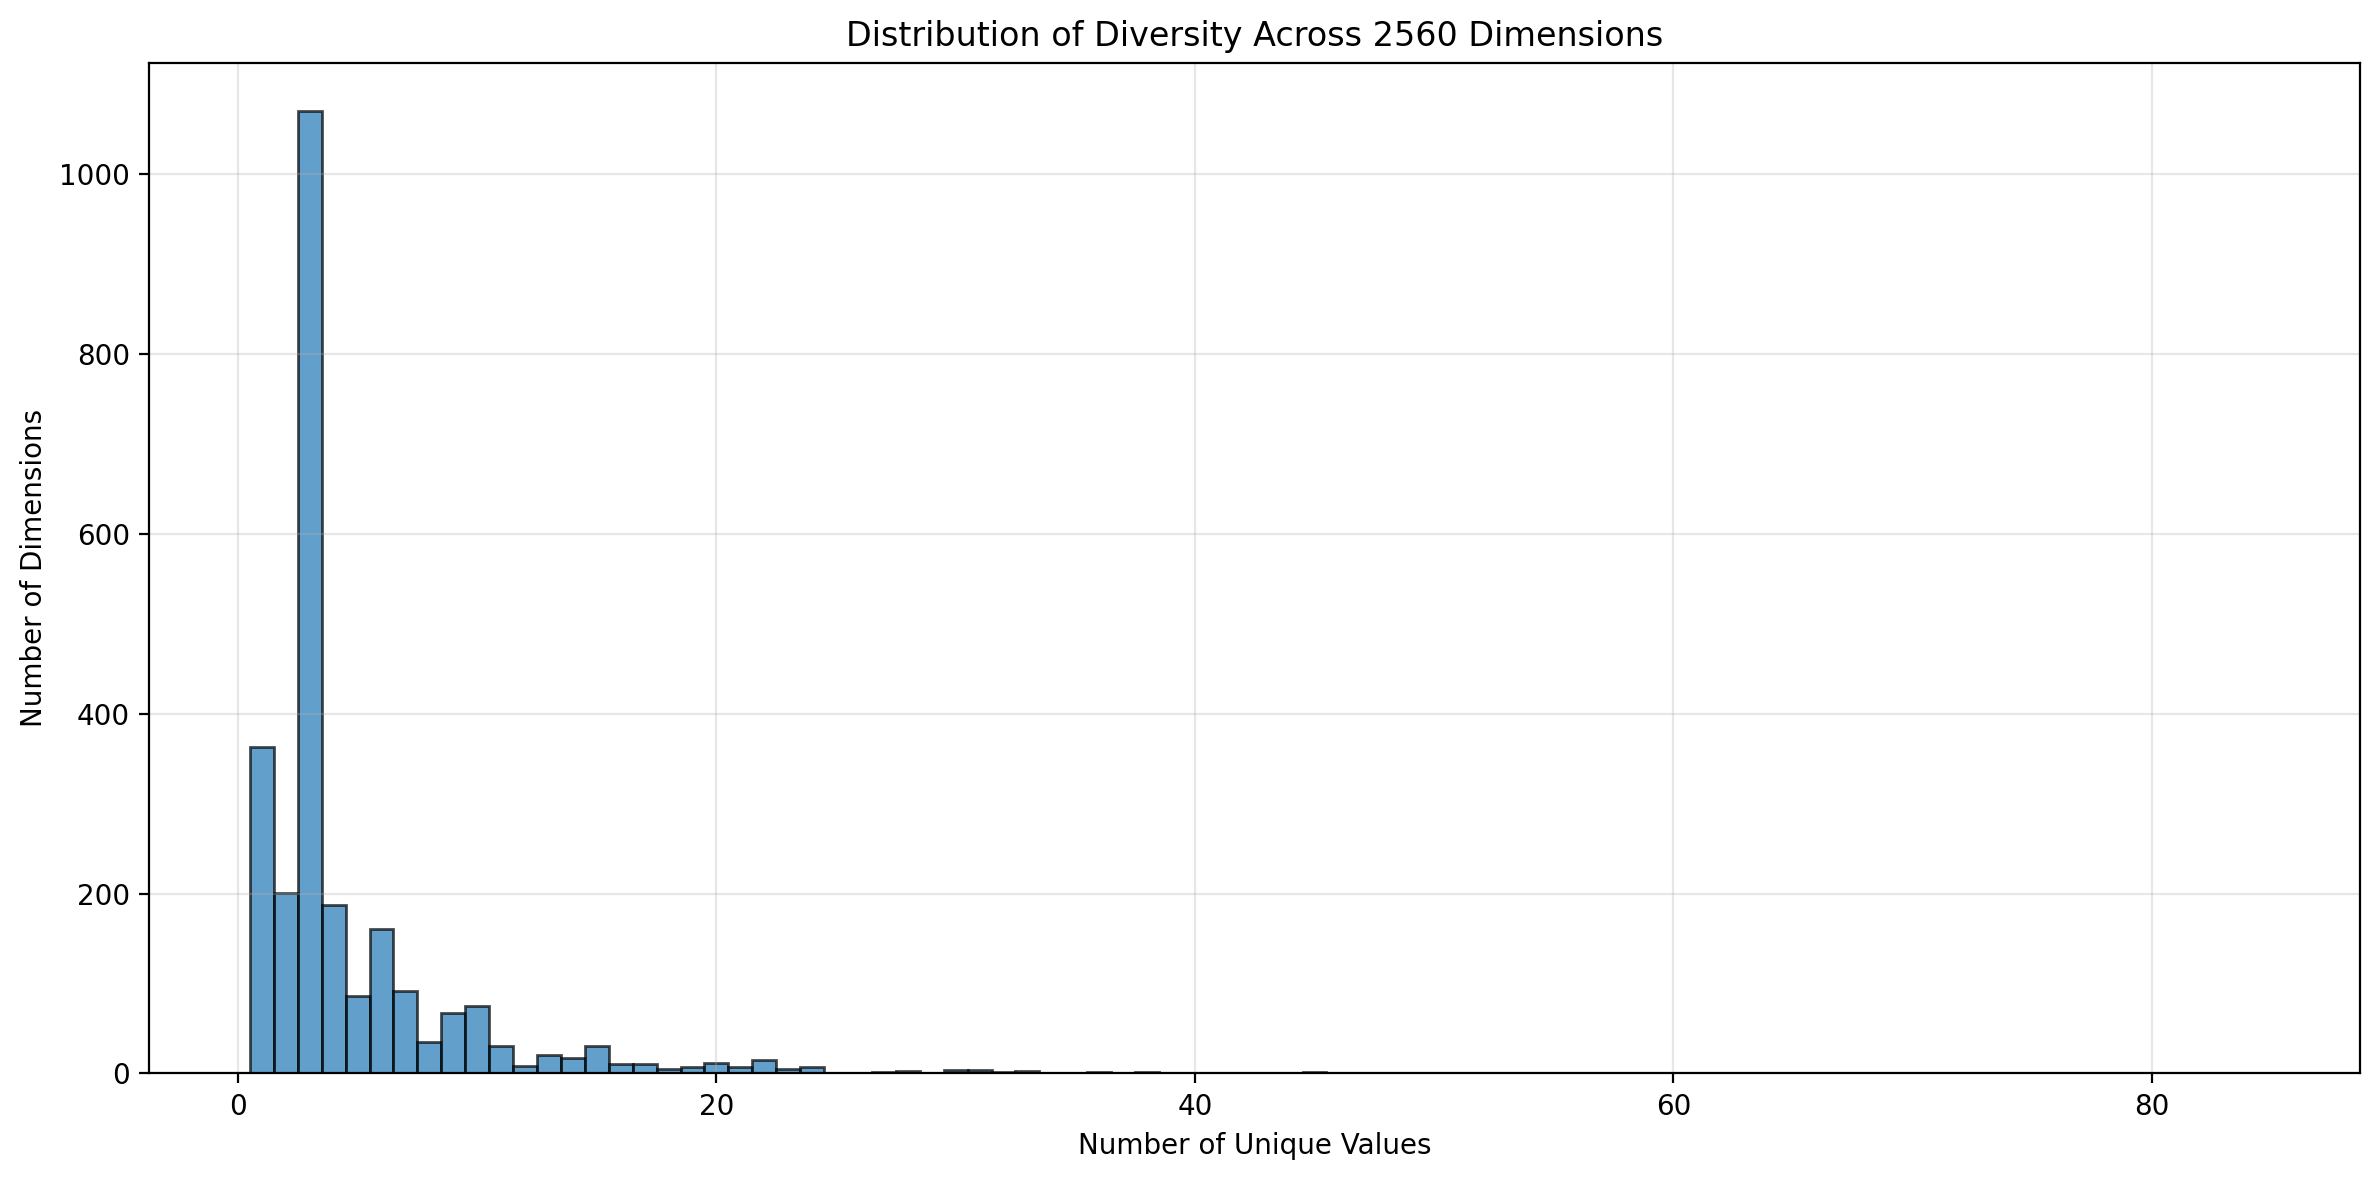

In [10]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

# Histogram
bins = np.arange(0.5, unique_counts.max() + 1.5, 1)
ax.hist(unique_counts, bins=bins, edgecolor='black', alpha=0.7)

ax.set_xlabel('Number of Unique Values')
ax.set_ylabel('Number of Dimensions')
ax.set_title(f'Distribution of Diversity Across {num_dims} Dimensions')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Identify Most Diverse Dimensions

In [11]:
# Find dimensions with most unique values
top_indices = np.argsort(unique_counts)[::-1][:TOP_N_DIMS]

print(f"Top {TOP_N_DIMS} most diverse dimensions:")
print(f"{'Rank':<6} {'Dimension':<12} {'Unique Values':<15} {'Fraction':<10}")
print("-" * 50)

for rank, dim_idx in enumerate(top_indices, 1):
    n_unique = unique_counts[dim_idx]
    fraction = n_unique / len(unique_vectors)
    print(f"{rank:<6} {dim_idx:<12} {n_unique:<15} {fraction:.3f}")

Top 10 most diverse dimensions:
Rank   Dimension    Unique Values   Fraction  
--------------------------------------------------
1      1382         84              0.672
2      1008         78              0.624
3      1435         68              0.544
4      1718         66              0.528
5      1362         57              0.456
6      727          52              0.416
7      1662         49              0.392
8      1207         48              0.384
9      573          46              0.368
10     1511         45              0.360


## Value Distributions for Top Dimensions

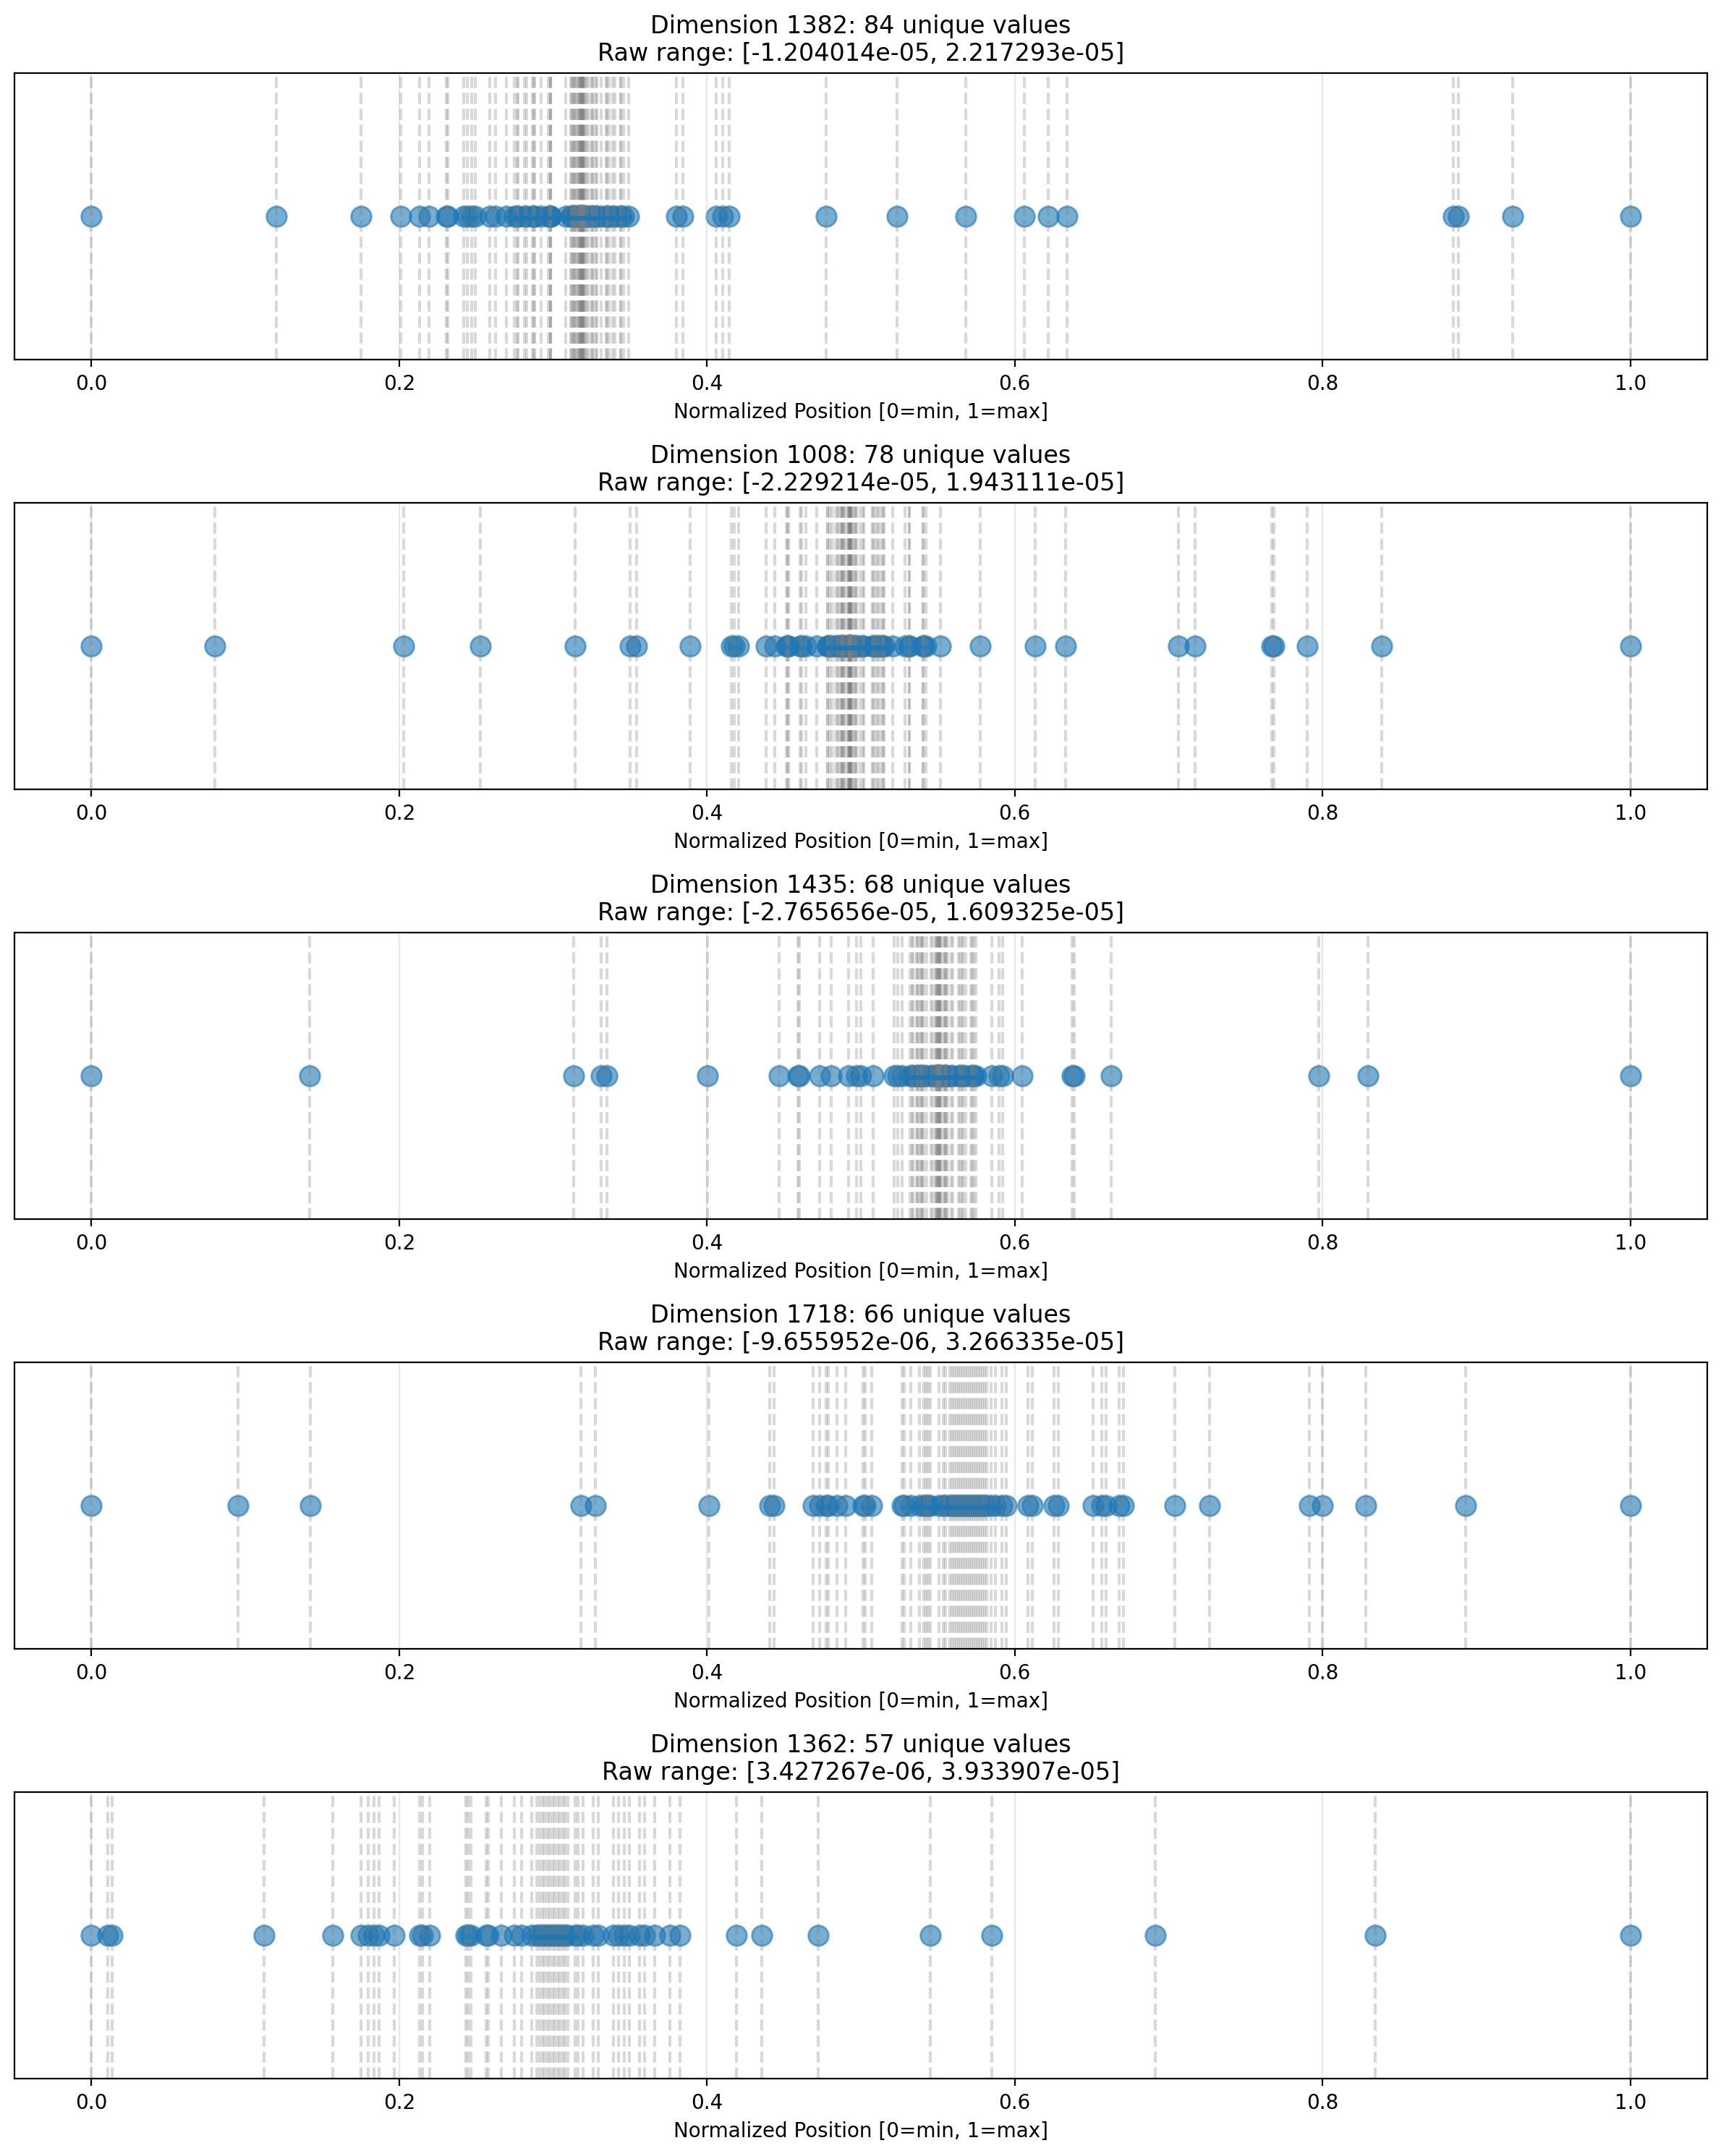

In [12]:
# Show actual value distributions for most diverse dimensions
n_show = min(5, TOP_N_DIMS)

fig, axes = plt.subplots(n_show, 1, figsize=(12, 3*n_show), dpi=DPI)
if n_show == 1:
    axes = [axes]

for i, dim_idx in enumerate(top_indices[:n_show]):
    ax = axes[i]
    
    # Get values for this dimension
    values = unique_vectors[:, dim_idx].to(torch.float32).cpu().numpy()
    unique_vals = np.unique(values)
    
    # Normalize to [0, 1]
    v_min, v_max = values.min(), values.max()
    if v_max > v_min:
        values_norm = (values - v_min) / (v_max - v_min)
        unique_vals_norm = (unique_vals - v_min) / (v_max - v_min)
    else:
        values_norm = np.zeros_like(values)
        unique_vals_norm = np.zeros_like(unique_vals)
    
    # Plot unique value positions
    ax.scatter(unique_vals_norm, np.zeros_like(unique_vals_norm), s=100, alpha=0.6)
    
    # Add vertical lines
    for val in unique_vals_norm:
        ax.axvline(val, color='gray', alpha=0.3, linestyle='--')
    
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel('Normalized Position [0=min, 1=max]')
    ax.set_yticks([])
    ax.set_title(f'Dimension {dim_idx}: {len(unique_vals)} unique values\n'
                 f'Raw range: [{v_min:.6e}, {v_max:.6e}]')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Spacing Analysis for Most Diverse Dimension

In [13]:
# Analyze spacing between values in the most diverse dimension
most_diverse_dim = top_indices[0]
values = unique_vectors[:, most_diverse_dim].to(torch.float32).cpu().numpy()
unique_vals = np.sort(np.unique(values))

print(f"Spacing analysis for dimension {most_diverse_dim}:")
print(f"  {len(unique_vals)} unique values")
print(f"\nActual values:")
print(unique_vals)

if len(unique_vals) > 1:
    gaps = np.diff(unique_vals)
    print(f"\nGaps between adjacent values:")
    print(gaps)
    print(f"\nGap statistics:")
    print(f"  Min: {gaps.min():.6e}")
    print(f"  Max: {gaps.max():.6e}")
    print(f"  Mean: {gaps.mean():.6e}")
    print(f"  Std: {gaps.std():.6e}")
    
    # Check if spacing is regular
    gap_variation = gaps.std() / gaps.mean() if gaps.mean() > 0 else 0
    print(f"\nRegularity (std/mean): {gap_variation:.4f}")
    if gap_variation < 0.1:
        print("  → Spacing appears regular (lattice-like)")
    else:
        print("  → Spacing appears irregular")

Spacing analysis for dimension 1382:
  84 unique values

Actual values:
[-1.2040138e-05 -7.9274178e-06 -6.0498714e-06 -5.1558018e-06
 -4.7385693e-06 -4.5299530e-06 -4.1425228e-06 -4.1127205e-06
 -3.7699938e-06 -3.6805868e-06 -3.5911798e-06 -3.5017729e-06
 -3.1888485e-06 -3.0547380e-06 -2.8163195e-06 -2.6375055e-06
 -2.5779009e-06 -2.5629997e-06 -2.4139881e-06 -2.3692846e-06
 -2.2351742e-06 -2.2053719e-06 -2.1904707e-06 -2.0414591e-06
 -1.8775463e-06 -1.8402934e-06 -1.8328428e-06 -1.8253922e-06
 -1.4975667e-06 -1.3783574e-06 -1.3634562e-06 -1.3336539e-06
 -1.3113022e-06 -1.2964010e-06 -1.2889504e-06 -1.2591481e-06
 -1.2218952e-06 -1.2069941e-06 -1.1920929e-06 -1.1771917e-06
 -1.1697412e-06 -1.1548400e-06 -1.1473894e-06 -1.1399388e-06
 -1.1324883e-06 -1.1250377e-06 -1.1175871e-06 -1.1101365e-06
 -1.1026859e-06 -1.0952353e-06 -1.0877848e-06 -1.0579824e-06
 -1.0356307e-06 -9.9837780e-07 -9.3504786e-07 -8.9406967e-07
 -8.7916851e-07 -8.2701445e-07 -7.9721212e-07 -7.0035458e-07
 -5.8859587e-

## Smallest Pairwise Distance / ULP